# Imports

In [2]:
from os.path import join, isdir
from os import makedirs
import einops
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import model
from coco_fake_dataset import COCOFakeDataset

/home/rom42pla/repos/binary_deepfake_detection/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parameters

In [3]:
coco2014_path = join("..", "..", "datasets", "coco2014")
coco_fake_path = join("..", "..", "datasets", "fake_coco")
images_path = join(".", "images")
pretrained_model_path = join("images", "coco_fake_S_epoch=4-train_acc=0.93-val_acc=0.93.ckpt")

# Dataset loading

In [4]:
dataset = COCOFakeDataset(
        coco2014_path=coco2014_path,
        coco_fake_path=coco_fake_path,
        split="val",
        mode="single",
        resolution=224,
    )

In [5]:
dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=1,
    )

# Model creation

In [7]:
net = model.BNext4DFR.load_from_checkpoint(pretrained_model_path, map_location="cpu")

/home/rom42pla/repos/binary_deepfake_detection/.conda/lib/python3.11/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.1.4


Model with ELM Attention and Infor-Recoupling


# Plotting

In [8]:
# creates the images dir
from os import makedirs
if not isdir(images_path):
    makedirs(images_path)

torch.Size([1536])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


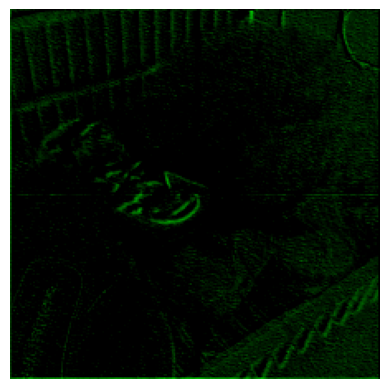

In [16]:
for batch in dataloader:
    import torch
    import timm
    # adds the new channels to the image
    image_augmented = net.add_new_channels(batch["image"])
    image_adapted = net.adapter(image_augmented).detach().cpu()
    image_adapted = (image_adapted - torch.as_tensor(timm.data.constants.IMAGENET_DEFAULT_MEAN).view(1, -1, 1, 1)) / torch.as_tensor(timm.data.constants.IMAGENET_DEFAULT_STD).view(1, -1, 1, 1)
    features = net.base_model(image_adapted)[0]
    image_adapted = einops.rearrange(image_adapted[0], "c h w -> h w c")
    rgb_image = einops.rearrange(image_augmented[0, :3], "c h w -> h w c")
    fft_image = image_augmented[0, -2]
    lbp_image = image_augmented[0, -1]
    # plots each channel of the augmented image
    for image, title in [
        (rgb_image, "rgb"),
        (fft_image, "fft"),
        (lbp_image, "lbp"),
        (image_adapted, "adapted"),
        ]:
        plt.imshow(image)
        plt.axis('off')
        plt.savefig(join(images_path, f"{title}.png"), bbox_inches='tight', pad_inches=0, dpi=300)
    break